# Fitovanje tranzita egzoplaneta koristeći PyMC i Exoplanet

Kroz ovaj notebook ćemo fitovati krivu sjaja zvezde WASP-18 koristeći TESS podatke, sa ciljem da na kraju dobijemo parametre egzoplanete WASP-18 b na osnovu fitovane krive sjaja. Koristićemo paket `exoplanet` i njegov dependency `pymc`.

In [1]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import pymc_ext as pmx
import pytensor.tensor as pt
import exoplanet as xo
import arviz as az
import corner

c:\Users\spnem\AppData\Local\Programs\Python\Python313\Lib\site-packages\pymc_ext\optim.py:4: FutureWarning: `pytensor.graph.basic.graph_inputs` was moved to `pytensor.graph.traversal.graph_inputs`. Calling it from the old location will fail in a future release.
  from pytensor.graph.basic import graph_inputs


## 1. Prikupljanje i obrada podataka

Za početak ćemo preuzeti TESS Data Validation podatke preko MAST APIja. Želimo TESS Input Catalog ID (TIC ID) i Threshold Crossing Event (TCE) podatke za planetu WASP-18 b.

In [2]:
print("Preuzimanje podataka sa MAST API...")

planeturl = "https://exo.mast.stsci.edu/api/v0.1/exoplanets/"
dvurl = "https://exo.mast.stsci.edu/api/v0.1/dvdata/tess/"
header = {}

planet_name = "WASP-18 b"

# Pronalazi TIC ID i TCE
url = planeturl + "/identifiers/"
myparams = {"name": planet_name}
r = requests.get(url=url, params=myparams, headers=header)
planet_names = r.json()
ticid = planet_names['tessID']
tce = planet_names['tessTCE']
print(f"Pronađen TIC ID: {ticid} i TCE: {tce}")

# Pronalazi dostupne sektore
url = dvurl + str(ticid) + '/tces/'
myparams = {"tce": tce}
r = requests.get(url=url, params=myparams, headers=header)
sectorInfo = r.json()
sectors = [x[:11] for x in sectorInfo["TCE"] if tce in x]
print(f"Pronađeni sektori: {sectors}")

# Koristićemo samo prvi dostupni sektor za ovu analizu
sector = sectors[0]

# Preuzima info
url = dvurl + str(ticid) + '/info/'
myparams = {"tce": tce, "sector": sector}
r = requests.get(url=url, params=myparams, headers=header)
tceInfo = r.json()

# Preuzima tabelu sa svetlosnom krivom
url = dvurl + str(ticid) + '/table/'
myparams = {"tce": tce, "sector": sector}
r = requests.get(url=url, params=myparams, headers=header)
tce_data = r.json()
data = pd.DataFrame.from_dict(tce_data['data'])

print("Podaci uspešno preuzeti.")


Preuzimanje podataka sa MAST API...
Pronađen TIC ID: 100100827 i TCE: TCE_1
Pronađeni sektori: ['s0001-s0003', 's0001-s0036', 's0001-s0069', 's0002-s0002', 's0003-s0003', 's0029-s0029', 's0030-s0030', 's0069-s0069', 's0096-s0096']
Podaci uspešno preuzeti.


Sada ćemo obraditi podatke. Izdvajamo fluks za svaki dostupan trenutak u vremenu, i filtriramo NaN vrednosti. Koristimo standardnu devijaciju iz reziduala za procenu greške i izdvajamo početne vrednosti za orbitalni period, t0 i r.

In [3]:
# Izdvajamo relevantne kolone
time_raw = np.array(data['PHASE'], dtype=float)
flux_raw = np.array(data['LC_DETREND'], dtype=float)
model_init_raw = np.array(data['MODEL_INIT'], dtype=float)

# Filtriramo NaN vrednosti
nan_mask = ~np.isnan(flux_raw) & ~np.isnan(model_init_raw)

time = time_raw[nan_mask]
flux = flux_raw[nan_mask]
model_init = model_init_raw[nan_mask]

# Procena greške: Koristimo standardnu devijaciju reziduala iz inicijalnog MAST modela kao procenu uniformne greške.
residuals = flux - model_init
yerr = np.std(residuals)
print(f"Procenjena greška merenja (yerr): {yerr:.6f}")

# Izdvajamo početne vrednosti
period_init = float(tceInfo['DV Data Header']['TPERIOD'])
t0_init = float(tceInfo['DV Data Header']['TEPOCH'])
r_star = float(tceInfo['DV Primary Header']['RADIUS'])
r_planet_re = float(tceInfo['DV Data Header']['PRADIUS'])
r_planet_rsun = r_planet_re / 109.07
r_init = r_planet_rsun / r_star

# Imam bugove bez ovoga - osiguravamo uniformne oblike nizova
time = np.asarray(time).ravel().astype(np.float64)   # (N,)
flux = np.asarray(flux).ravel().astype(np.float64)   # (N,)

if np.ndim(yerr) > 0:
    yerr = np.asarray(yerr).ravel().astype(np.float64)
else:
    yerr = float(yerr)


print(f"Početne vrednosti: Period={period_init:.4f}, T0={t0_init:.4f}, R_p/R_*={r_init:.4f}")

Procenjena greška merenja (yerr): 0.000638
Početne vrednosti: Period=0.9414, T0=1354.4580, R_p/R_*=0.0884


Kako smo iz ovog dataseta dobili podatke za preko 31000 tačaka, MCMC radi sporije nego što bismo želeli. Kako je većina njih jako blizu ostalima, autor ovog notebooka je došao na ideju da nasumično odbaci određen procenat podataka radi efikasnosti. Ovo jeste takođe i odbacivanje informacija o tranzitu, i zato je opcionalno. Podešavanje keep_fraction određuje koliki procenat dataseta želimo da zadržimo, i vrednost 1 kompletno neutrališe naredni blok koda.

In [4]:
keep_fraction = 1
step = int(1.0 / keep_fraction) # uzimamo svaki 1/keep_fraction-ti point

if step > 1:
    print(f"Original number of points: {len(time)}")
    
    time = time[::step]
    flux = flux[::step]
    if np.ndim(yerr) > 0: 
        yerr = yerr[::step]
    
    print(f"Subsampling: Using {len(time)} points (every {step}-th point).")
    
else:
    print(f"Not subsampling data. Using all {len(time)} points.")


# imam bug ako ne radim ovo, pazimo da su šejpovi dobri
time = np.asarray(time).ravel().astype(np.float64)
flux = np.asarray(flux).ravel().astype(np.float64)
if np.ndim(yerr) > 0:
    yerr = np.asarray(yerr).ravel().astype(np.float64)
else:
    yerr = float(yerr)

Not subsampling data. Using all 31761 points.


## 2. Priprema modela

Sada definišemo model koji ćemo koristiti u daljem fitovanju. On je samo početak, i koristićemo naredne očekivane vrednosti:

`mean`: odstupanje fluksa od nule, modelovano normalnom raspodelom centriranoj na nuli

`u`: quadratic limb darkening koeficijenti

`t0`: vreme referentnog tranzita, modelovano normalnom raspodelom

`logP`: prirodni logaritam orbitalnog perioda P, modelovan normalnom raspodelom

`log_r`: prirodni logaritam količnika prečnika planete i zvezde

`b`: impact parameter, modelovan uniformnom raspodelom između 0 i 1

Kreiraćemo i početnu exoplanet orbitu, kao i početni model krive sjaja zasnovan na njoj:

In [ ]:
with pm.Model() as model:

    # Srednja vrednost fluksa
    mean = pm.Normal("mean", mu=0.0, sigma=1.0, initval=0.0)

    # Parametri orbite
    #t0 = pm.Normal("t0", mu=t0_init, sigma=1.0, initval=t0_init) 
    #logP = pm.Normal("logP", mu=np.log(period_init), sigma=0.1, initval=np.log(period_init)) 
    #period = pm.Deterministic("period", pt.exp(logP))

    # testing: ovi parametri gore su zapravo deterministički i ne treba ih optimizovati
    logP = pm.Deterministic("logP", pt.as_tensor(np.log(period_init)))
    period = pm.Deterministic("period", pt.exp(logP)) # Keep this for the orbit
    t0 = pm.Deterministic("t0", pt.as_tensor(0.0)) # ovo možda treba nazad u pt.as_tensor(t0_init)
    #############

    u = xo.distributions.quad_limb_dark("u", initval=np.array([0.3, 0.2]))

    log_r_scalar = pm.Normal("log_r", mu=np.log(r_init), sigma=2.0, initval=np.log(r_init))
    r_scalar = pt.exp(log_r_scalar)
    r_vector = pt.reshape(r_scalar, (1,))
    r = pm.Deterministic("r", r_scalar)
    
    b = pm.Uniform("b", lower=0.0, upper=1.0, initval=0.5) 

    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b)

    light_curves = xo.LimbDarkLightCurve(u[0], u[1]).get_light_curve(
        orbit=orbit, r=r_vector, t=time, use_in_transit=False
    )
    
    light_curve_model = light_curves[:, 0] + mean

    pm.Deterministic("light_curve_model", light_curve_model)
    pm.Deterministic("light_curves", light_curves)

    # Likelihood funkcija
    pm.Normal("obs", mu=light_curve_model, sigma=yerr, observed=flux)

print("Model uspešno definisan.")

Model uspešno definisan.


Probaćemo da optimizujemo model i da dobijemo bolji fit koristeći PyMC. Pre nego što pokrenemo spori i zahtevni MCMC sampler, iskoristićemo Maximum A Posteriori (MAP) algoritam koji će izračunati argumente koji maksimizuju verovatnosnu raspodelu parametara koje smo u modelu definisali. Ovo će biti odličan početni korak za MCMC.

Output()

MAP rešenje pronađeno.
Grafik MAP fita sačuvan kao 'wasp18b_map_fit.png'


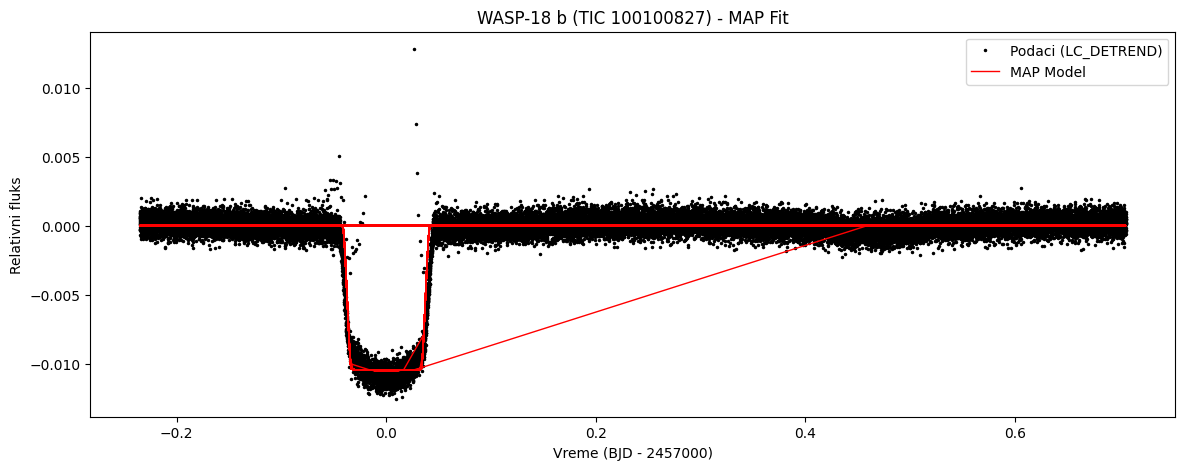

In [11]:
with model:
    map_soln = pm.find_MAP()

print("MAP rešenje pronađeno.")

# Iscrtavanje MAP modela preko podataka
plt.figure(figsize=(14, 5))
plt.plot(time, flux, ".k", ms=3, label="Podaci (LC_DETREND)")
plt.plot(time, map_soln["light_curve_model"], "r-", lw=1, label="MAP Model")
plt.xlabel("Vreme (BJD - 2457000)")
plt.ylabel("Relativni fluks")
plt.legend(fontsize=10)
plt.title(f"WASP-18 b (TIC {ticid}) - MAP Fit")
plt.savefig("wasp18b_map_fit.png")
print("Grafik MAP fita sačuvan kao 'wasp18b_map_fit.png'")

## 3. MCMC optimizacija modela

Nakon što je naš model dobio oblik, vreme je da počnemo sa MCMC semplovanjem. Naredni kod pokreće MCMC semplovanje kojim se istražuje prostor mogućih parametara. U pitanju je biased random walk, koji će izvući hiljadu potencijalnih parametara, ali će težiti ka verovatnijim vrednostima. Ovim putem ćemo dobiti aproksimativnu statističku raspodelu parametara modela.

In [15]:
import pytensor
pytensor.config.exception_verbosity = 'high'

print("\nPokretanje MCMC semplovanja")
np.random.seed(42)
with model:
    trace = pm.sample(
        tune=500,
        draws=500,
        start=map_soln,
        chains=2,
        target_accept=0.95,
        return_inferencedata=True,
    )

print("Semplovanje završeno.")


Pokretanje MCMC semplovanja


C:\Users\spnem\AppData\Local\Temp\ipykernel_9260\2977890912.py:7: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace = pm.sample(
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mean, __u_q1, __u_q2, log_r, b]
INFO:pymc.sampling.mcmc:NUTS: [mean, __u_q1, __u_q2, log_r, b]


Output()

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 705 seconds.
INFO:pymc.sampling.mcmc:Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 705 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
INFO:pymc.stats.convergence:We recommend running at least 4 chains for robust computation of convergence diagnostics


Semplovanje završeno.


## 4. Analiza rezultata

Ovde počinjemo sa analizom rezultata! Koristeći `az.summary` ćemo dobiti parametre za planetu na osnovu MCMC optimizacije. Ovaj korak generiše i čuva i tabelu vrednosti svih parametara. Generisaćemo i corner plot na kom vidimo 1D histograme za ključne parametre i 2D contour plotove koji pokazuju korelaciju parova parametara. Na kraju imamo i phase-folded plot, na osnovu kog možemo vizuelno da procenimo koliko je naš finalni fit dobar.


c:\Users\spnem\AppData\Local\Programs\Python\Python313\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
c:\Users\spnem\AppData\Local\Programs\Python\Python313\Lib\site-packages\arviz\stats\diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
period  0.941  0.000   0.941    0.941        0.0      0.0    1000.0    1000.0   
t0      0.000  0.000   0.000    0.000        0.0      NaN    1000.0    1000.0   
r       0.101  0.000   0.101    0.102        0.0      0.0     535.0     491.0   
b       0.002  0.002   0.000    0.005        0.0      0.0     515.0     301.0   
u[0]    0.169  0.008   0.154    0.184        0.0      0.0     528.0     538.0   
u[1]   -0.084  0.004  -0.092   -0.077        0.0      0.0     515.0     516.0   
mean    0.000  0.000   0.000    0.000        0.0      0.0     523.0     593.0   

        r_hat  
period    NaN  
t0        NaN  
r         1.0  
b         1.0  
u[0]      1.0  
u[1]      1.0  
mean      1.0  
Sažetak sačuvan kao 'wasp18b_summary.txt'
Corner plot sačuvan kao 'wasp18b_corner_plot.png'
Iscrtavanje fazno složene krive...
Fazno složen grafik sačuvan kao 'wasp18b_phase_fold.png'


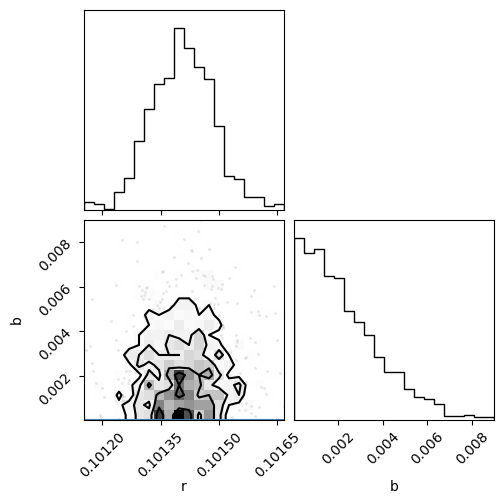

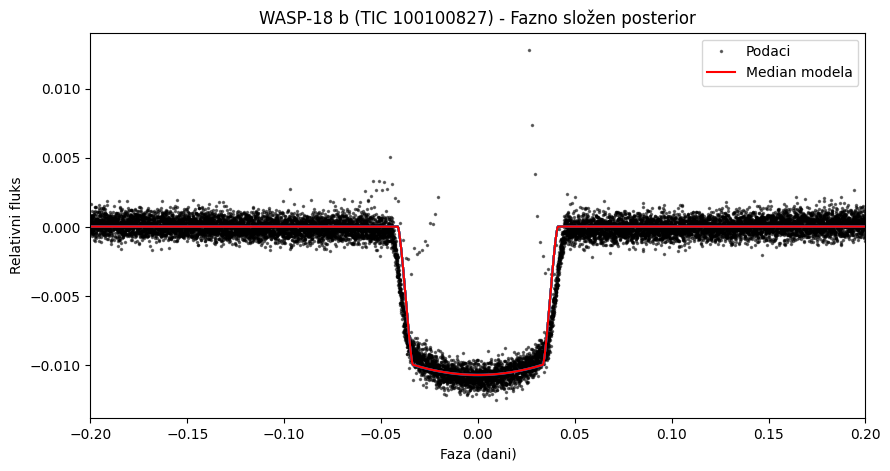

In [16]:
summary = az.summary(
    trace, var_names=["period", "t0", "r", "b", "u", "mean"]
)
print(summary)
with open("wasp18b_summary.txt", "w") as f:
    f.write(str(summary))
print("Sažetak sačuvan kao 'wasp18b_summary.txt'")

truth = dict(
    zip(
        ["r", "b"],
        (r_init, map_soln['b']),
    )
)
fig = corner.corner(
    trace,
    var_names=["r", "b"],
    truths=truth,
)
fig.savefig("wasp18b_corner_plot.png")
print("Corner plot sačuvan kao 'wasp18b_corner_plot.png'")

print("Iscrtavanje fazno složene krive...")
plt.figure(figsize=(10, 5))

p_med = np.median(trace.posterior["period"].values)
t0_med = np.median(trace.posterior["t0"].values)

#phase_time = (time - t0_med + 0.5 * p_med) % p_med - 0.5 * p_med
phase_time = time
sort_idx = np.argsort(phase_time)
plt.plot(phase_time[sort_idx], flux[sort_idx], ".k", ms=3, label="Podaci", alpha=0.5)

lc_data_array = trace.posterior["light_curve_model"]

stacked_lc = lc_data_array.stack(sample=("chain", "draw"))

lc_samples = stacked_lc.values.T 

# Iscrtavamo posteriorni model
# Uzimamo nasumičnih 100 uzoraka iz posteriora da pokažemo nesigurnost
idx = np.random.randint(0, len(lc_samples), 100)
for i in idx:
    plt.plot(phase_time[sort_idx], lc_samples[i][sort_idx], "C0-", alpha=0.05)

# Iscrtavamo medijanu modela
median_model = np.median(lc_samples, axis=0)
plt.plot(phase_time[sort_idx], median_model[sort_idx], "r-", label="Median modela")

plt.xlabel("Faza (dani)")
plt.ylabel("Relativni fluks")
plt.legend(fontsize=10)
plt.title(f"WASP-18 b (TIC {ticid}) - Fazno složen posterior")
plt.xlim(-0.2, 0.2) # Zumiramo na tranzit
plt.savefig("wasp18b_phase_fold.png")
print("Fazno složen grafik sačuvan kao 'wasp18b_phase_fold.png'")
